In [2]:
import os

os.environ['SPARK_HOME'] = r"C:\spark"
os.environ['PYSPARK_DRIVER_PYHTON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='lab'
os.environ['PYSPARK_PYTHON']='python'


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018")

print("Path to dataset files:", path)


C:\Users\khansa resqi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\khansa resqi\.cache\kagglehub\datasets\yuanyuwendymu\airline-delay-and-cancellation-data-2009-2018\versions\1


In [4]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T 
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import warnings
warnings.filterwarnings('ignore')

In [5]:
spark = SparkSession.builder.config("spark.executor.memory","2g").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [6]:
file_names_range = list(range(2009, 2018))
file_paths = [fr'C:\Users\khansa resqi\.cache\kagglehub\datasets\yuanyuwendymu\airline-delay-and-cancellation-data-2009-2018\versions\1\{file}.csv' for file in file_names_range]

In [7]:
schema = T.StructType([
    T.StructField("FL_DATE", T.TimestampType(), nullable=True),
    T.StructField("OP_CARRIER", T.StringType(), nullable=True),
    T.StructField("OP_CARRIER_FL_NUM", T.IntegerType(), nullable=True),
    T.StructField("ORIGIN", T.StringType(), nullable=True),
    T.StructField("DEST", T.StringType(), nullable=True),
    T.StructField("CRS_DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_DELAY", T.DoubleType(), nullable=True),
    T.StructField("TAXI_OUT", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_OFF", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_ON", T.DoubleType(), nullable=True),
    T.StructField("TAXI_IN", T.DoubleType(), nullable=True),
    T.StructField("CRS_ARR_TIME", T.DoubleType(), nullable=True),
    T.StructField("ARR_TIME",T.DoubleType(), nullable=True),
    T.StructField("ARR_DELAY", T.DoubleType(), nullable=True),
    T.StructField("CANCELLED", T.DoubleType(), nullable=True),
    T.StructField("CANCELLATION_CODE", T.StringType(), nullable=True),
    T.StructField("DIVERTED", T.DoubleType(), nullable=True),
    T.StructField("CRS_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("ACTUAL_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("AIR_TIME", T.DoubleType(), nullable=True),
    T.StructField("DISTANCE", T.DoubleType(), nullable=True),
    T.StructField("CARRIER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("WEATHER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("NAS_DELAY", T.DoubleType(), nullable=True),
    T.StructField("SECURITY_DELAY", T.DoubleType(), nullable=True),
    T.StructField("LATE_AIRCRAFT_DELAY", T.DoubleType(), nullable=True),
    T.StructField("Unnamed: 27", T.StringType(), nullable=True)
])

In [8]:
df = spark.read.schema(schema).format("csv").option("header", "true").load(file_paths)

In [9]:
# remove null values from the cols used for classification:
df = df.dropna(subset= [
    'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'DISTANCE'])

# save df for analysis
analysis_df = df

In [10]:

classify_df = df.drop("Unnamed: 27", 
                        "CARRIER_DELAY", 
                        "WEATHER_DELAY",
                        "NAS_DELAY",
                        "SECURITY_DELAY",
                        "LATE_AIRCRAFT_DELAY",
                        "CANCELLATION_CODE",
                        "DEP_TIME",
                        "DEP_DELAY",
                        "TAXI_OUT",
                        "WHEELS_OFF",
                        "WHEELS_ON",
                        "TAXI_IN",
                        "ARR_TIME",
                        "ARR_DELAY",
                        "ACTUAL_ELAPSED_TIME", 
                        "AIR_TIME")

In [11]:
classify_df = classify_df.withColumn("FL_DATE", F.unix_timestamp("FL_DATE"))

In [12]:
classify_df.columns

['FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'DISTANCE']

In [13]:
pos_df = classify_df.filter(F.col('CANCELLED').isin(1)).sample(fraction=0.1)
# select an equal amount of negative samples (number of neg samples == number of pos samples)
neg_df = classify_df.filter(F.col('CANCELLED').isin(0)).orderBy(F.rand()).limit(pos_df.count())


# balanced df - a subset - around 141k
classify_df = pos_df.union(neg_df).sample(fraction=1.0).cache()


In [14]:
carriers_flight_count_df = analysis_df.groupBy(F.col('OP_CARRIER')).count().orderBy(F.col('count').desc())
top_10 = carriers_flight_count_df.limit(10).toPandas()
top_10 = top_10.rename(columns={'OP_CARRIER':'Carrier'})
top_10

,Carrier,count
0,WN,10743987
1,DL,6892597
2,AA,5765343
3,OO,5488915
4,EV,4523555
5,UA,4205093
6,MQ,2920259
7,US,2657286
8,B6,2178956
9,AS,1414778


In [15]:

import altair as alt
chart = alt.Chart(top_10).mark_arc(outerRadius=260, innerRadius=75).encode(
    theta = alt.Theta(field="count", type="quantitative", stack=True),
    color = alt.Color('Carrier:N', scale=alt.Scale(scheme='category20'), legend=None),
).properties(
    title='Top 10 Carriers by amount of flights',
    width=600,
    height=300
)

pie = chart.mark_arc(outerRadius=350)
value_text = pie.mark_text(radius=300, size=15).encode(text=alt.Text('count:Q'))

pie2 = chart.mark_arc(outerRadius=250)
text = pie2.mark_text(radius=200, size=15).encode(
    text=alt.Text('Carrier:N'), 
    color=alt.value("#000000")
)

(chart + text + value_text).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=18
)

alt.LayerChart(...)

In [16]:



carriers_flight_count_df = analysis_df.filter(F.col('CANCELLATION_CODE').isNotNull()).groupBy(F.col('CANCELLATION_CODE')).count()
cancellation_reasons = carriers_flight_count_df.toPandas()
cancellation_reasons

,CANCELLATION_CODE,count
0,B,414449
1,C,155532
2,A,285946
3,D,664


In [17]:
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'A'] = 'By carrier'
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'B'] = 'Due to weather'
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'C'] = 'By national air system'
cancellation_reasons['CANCELLATION_CODE'][cancellation_reasons['CANCELLATION_CODE'] == 'D'] = 'For security'
cancellation_reasons = cancellation_reasons.rename(columns={'CANCELLATION_CODE':'Reason'})

In [18]:
cancellation_reasons

,Reason,count
0,Due to weather,414449
1,By national air system,155532
2,By carrier,285946
3,For security,664


In [19]:
chart = alt.Chart(cancellation_reasons).mark_arc(outerRadius=180, innerRadius=50).encode(
    theta = alt.Theta(field="count", type="quantitative", stack=True),
    color = alt.Color('Reason:N', scale=alt.Scale(scheme='category20'), legend=None),
).properties(
    title='Reasons for flight cancellations',
    width=600,
    height=300
)

pie = chart.mark_arc(outerRadius=250)
value_text = pie.mark_text(radius=220, size=15).encode(text=alt.Text('count:Q'))

pie2 = chart.mark_arc(outerRadius=150)
text = pie2.mark_text(radius=120, size=12).encode(
    text=alt.Text('Reason:N'), 
    color=alt.value("#000000")
)

(chart + text + value_text).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=18
)

alt.LayerChart(...)

In [20]:
print(classify_df.head())

Row(FL_DATE=1230742800, OP_CARRIER='YV', OP_CARRIER_FL_NUM=7065, ORIGIN='EWR', DEST='IAD', CRS_DEP_TIME=1013.0, CRS_ARR_TIME=1139.0, CANCELLED=1.0, DIVERTED=0.0, CRS_ELAPSED_TIME=86.0, DISTANCE=213.0)


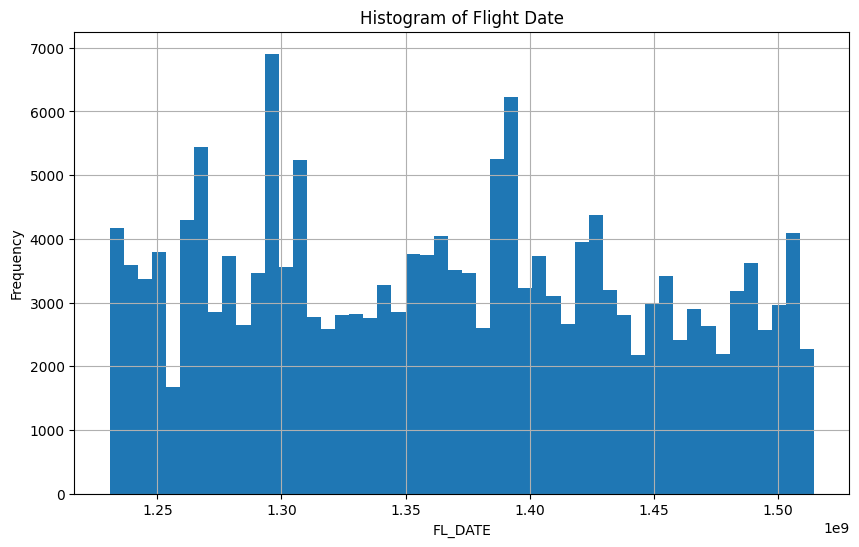

In [21]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pdf = classify_df.select('FL_DATE').toPandas()

# Plot histogram
pdf['FL_DATE'].hist(bins=50, figsize=(10, 6))
plt.xlabel('FL_DATE')
plt.ylabel('Frequency')
plt.title('Histogram of Flight Date')
plt.grid(True)
plt.show()


In [22]:
print(pdf.head())

      FL_DATE
0  1230742800
1  1230742800
2  1230742800
3  1230742800
4  1230742800


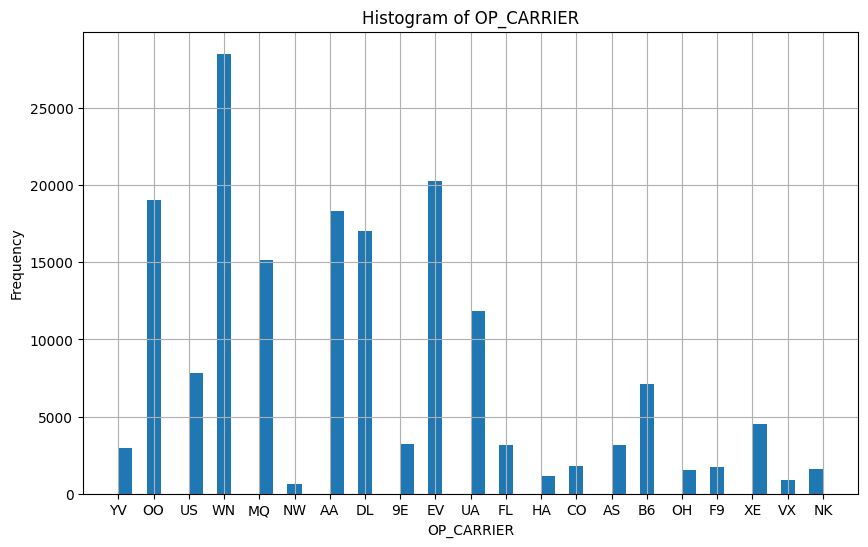

In [23]:
pdf = classify_df.select('OP_CARRIER').toPandas()
# Plot histogram
pdf['OP_CARRIER'].hist(bins=50, figsize=(10, 6))
plt.xlabel('OP_CARRIER')
plt.ylabel('Frequency')
plt.title('Histogram of OP_CARRIER')
plt.grid(True)
plt.show()

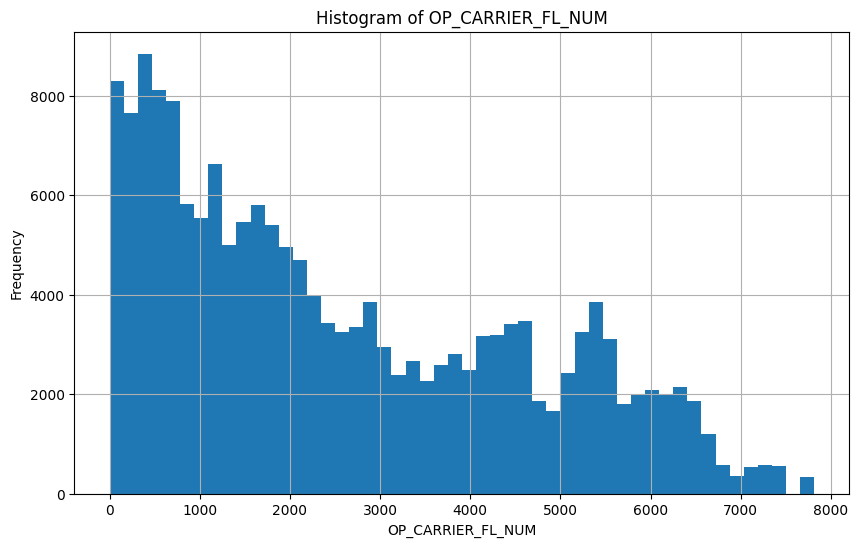

In [24]:
pdf = classify_df.select('OP_CARRIER_FL_NUM').toPandas()
# Plot histogram
pdf['OP_CARRIER_FL_NUM'].hist(bins=50, figsize=(10, 6))
plt.xlabel('OP_CARRIER_FL_NUM')
plt.ylabel('Frequency')
plt.title('Histogram of OP_CARRIER_FL_NUM')
plt.grid(True)
plt.show()

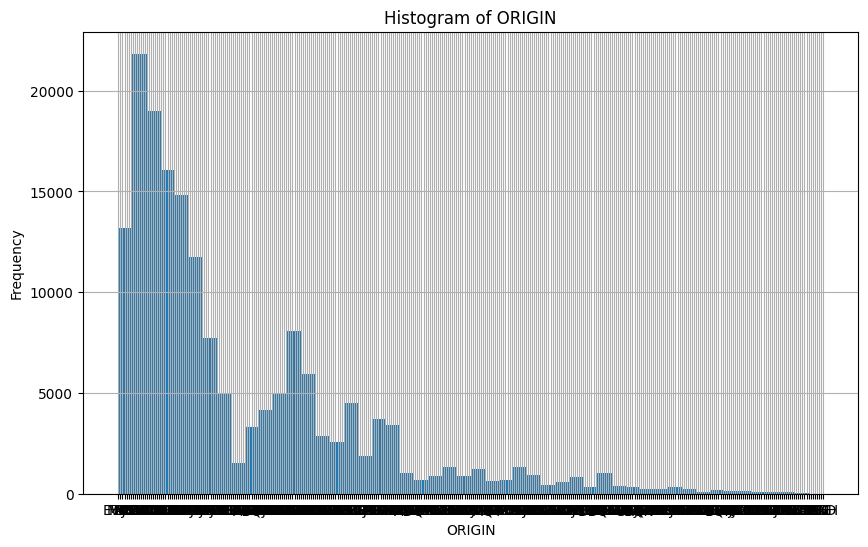

In [25]:
pdf = classify_df.select('ORIGIN').toPandas()
# Plot histogram
pdf['ORIGIN'].hist(bins=50, figsize=(10, 6))
plt.xlabel('ORIGIN')
plt.ylabel('Frequency')
plt.title('Histogram of ORIGIN')
plt.grid(True)
plt.show()

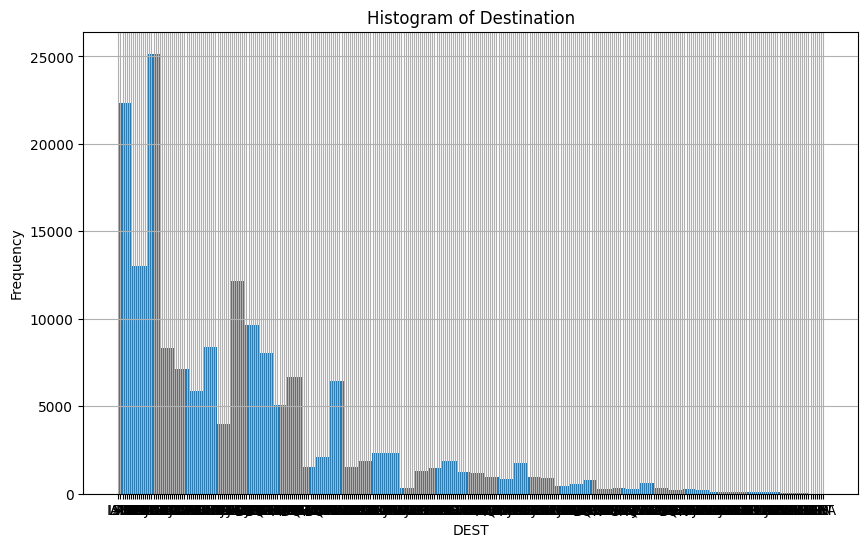

In [26]:
pdf = classify_df.select('DEST').toPandas()
# Plot histogram
pdf['DEST'].hist(bins=50, figsize=(10, 6))
plt.xlabel('DEST')
plt.ylabel('Frequency')
plt.title('Histogram of Destination')
plt.grid(True)
plt.show()

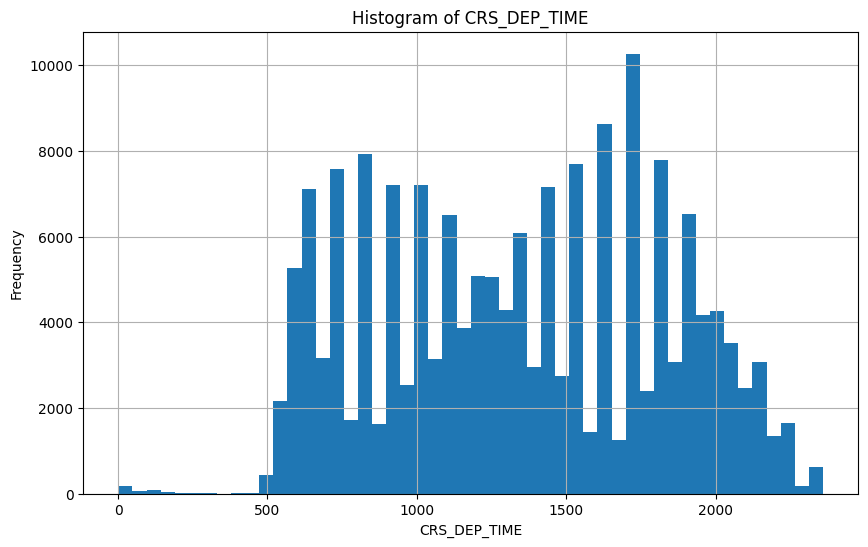

In [27]:
pdf = classify_df.select('CRS_DEP_TIME').toPandas()
# Plot histogram
pdf['CRS_DEP_TIME'].hist(bins=50, figsize=(10, 6))
plt.xlabel('CRS_DEP_TIME')
plt.ylabel('Frequency')
plt.title('Histogram of CRS_DEP_TIME')
plt.grid(True)
plt.show()

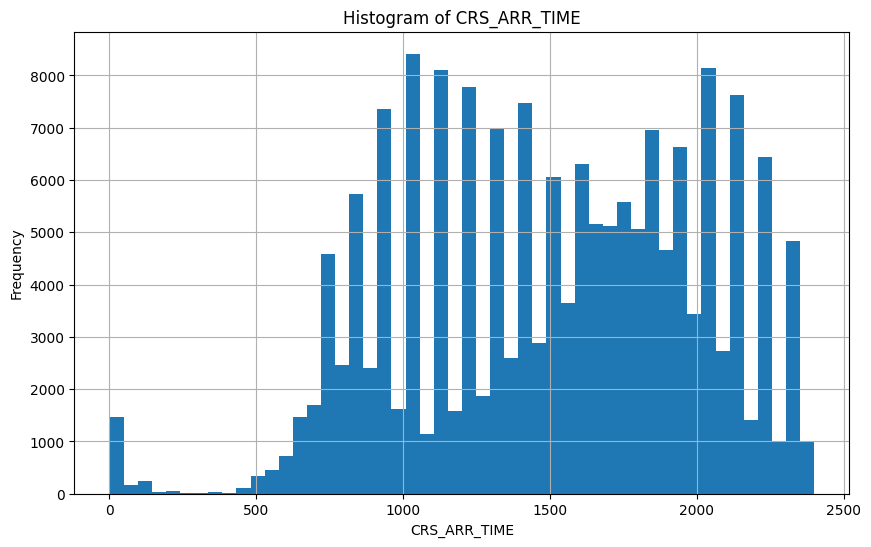

In [28]:
pdf = classify_df.select('CRS_ARR_TIME').toPandas()
# Plot histogram
pdf['CRS_ARR_TIME'].hist(bins=50, figsize=(10, 6))
plt.xlabel('CRS_ARR_TIME')
plt.ylabel('Frequency')
plt.title('Histogram of CRS_ARR_TIME')
plt.grid(True)
plt.show()

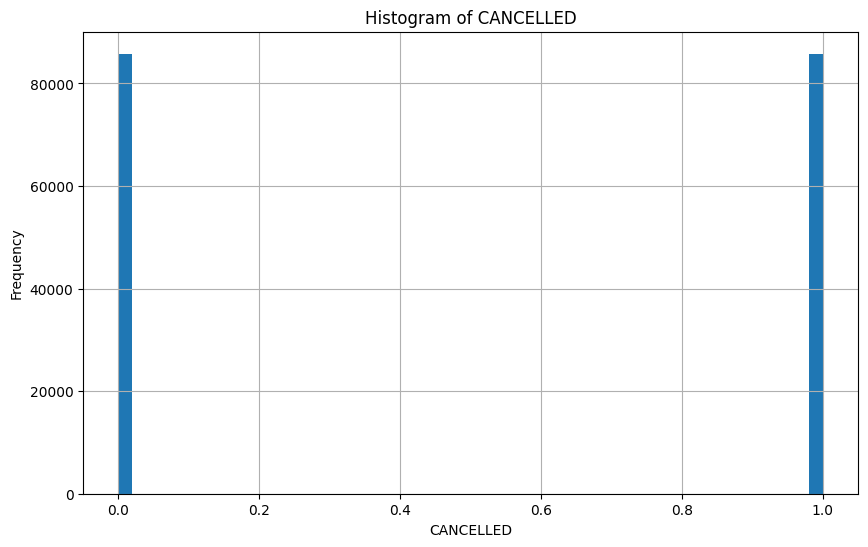

In [29]:
pdf = classify_df.select('CANCELLED').toPandas()
# Plot histogram
pdf['CANCELLED'].hist(bins=50, figsize=(10, 6))
plt.xlabel('CANCELLED')
plt.ylabel('Frequency')
plt.title('Histogram of CANCELLED')
plt.grid(True)
plt.show()

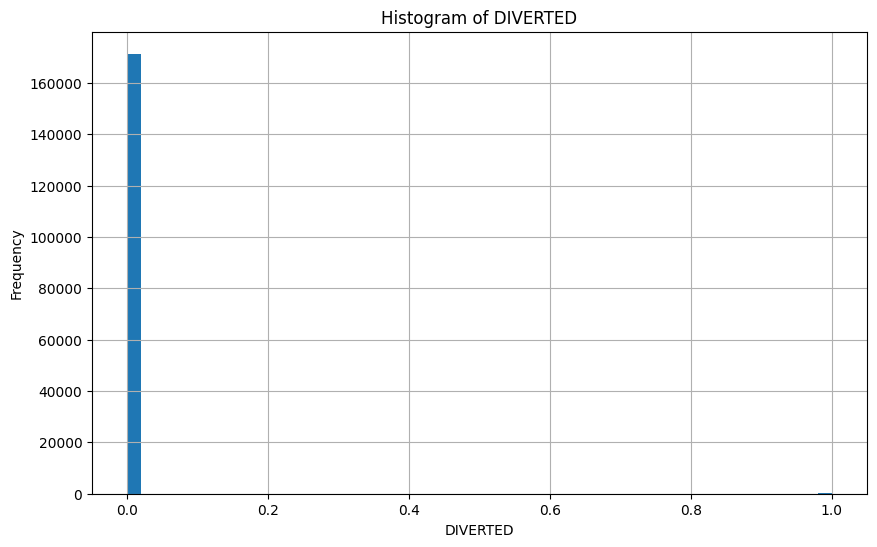

In [30]:
pdf = classify_df.select('DIVERTED').toPandas()
# Plot histogram
pdf['DIVERTED'].hist(bins=50, figsize=(10, 6))
plt.xlabel('DIVERTED')
plt.ylabel('Frequency')
plt.title('Histogram of DIVERTED')
plt.grid(True)
plt.show()

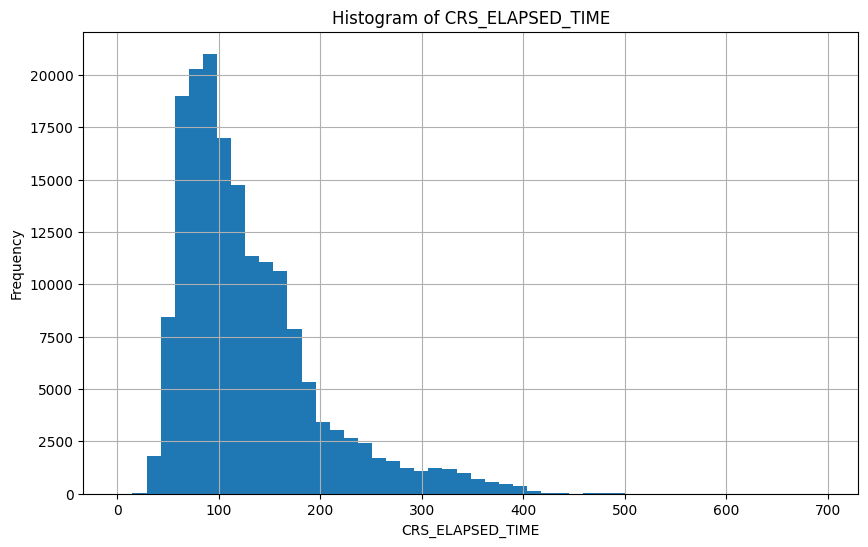

In [32]:
pdf = classify_df.select('CRS_ELAPSED_TIME').toPandas()
# Plot histogram
pdf['CRS_ELAPSED_TIME'].hist(bins=50, figsize=(10, 6))
plt.xlabel('CRS_ELAPSED_TIME')
plt.ylabel('Frequency')
plt.title('Histogram of CRS_ELAPSED_TIME')
plt.grid(True)
plt.show()

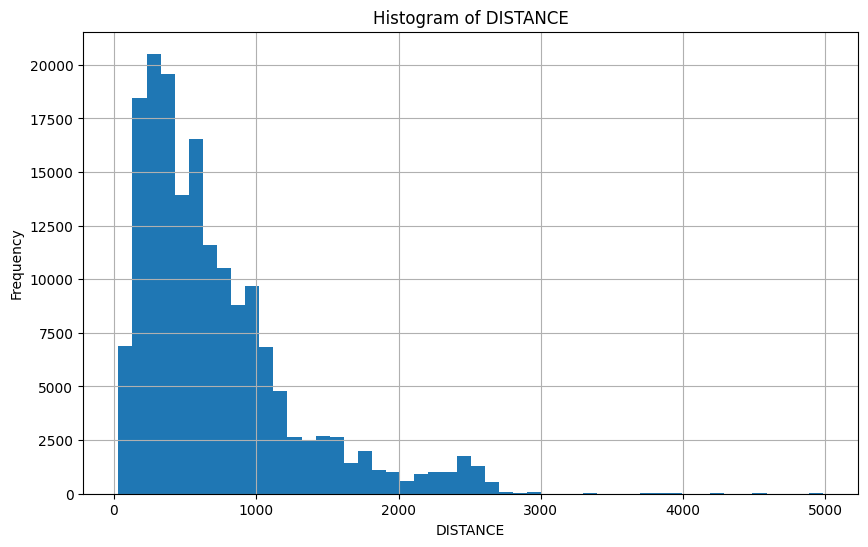

In [33]:
pdf = classify_df.select('DISTANCE').toPandas()
# Plot histogram
pdf['DISTANCE'].hist(bins=50, figsize=(10, 6))
plt.xlabel('DISTANCE')
plt.ylabel('Frequency')
plt.title('Histogram of DISTANCE')
plt.grid(True)
plt.show()

In [34]:
pdf = classify_df.toPandas()
print(pdf.head())

      FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  \
0  1230742800         YV               7065    EWR  IAD        1013.0   
1  1230742800         YV               2984    FAT  LAS         710.0   
2  1230742800         OO               4537    MOB  ATL        1305.0   
3  1230742800         OO               5702    SJC  SBA        1051.0   
4  1230742800         OO               5703    SJC  SBA        1706.0   

   CRS_ARR_TIME  CANCELLED  DIVERTED  CRS_ELAPSED_TIME  DISTANCE  
0        1139.0        1.0       0.0              86.0     213.0  
1         820.0        1.0       0.0              70.0     258.0  
2        1519.0        1.0       0.0              74.0     302.0  
3        1153.0        1.0       0.0              62.0     234.0  
4        1808.0        1.0       0.0              62.0     234.0  


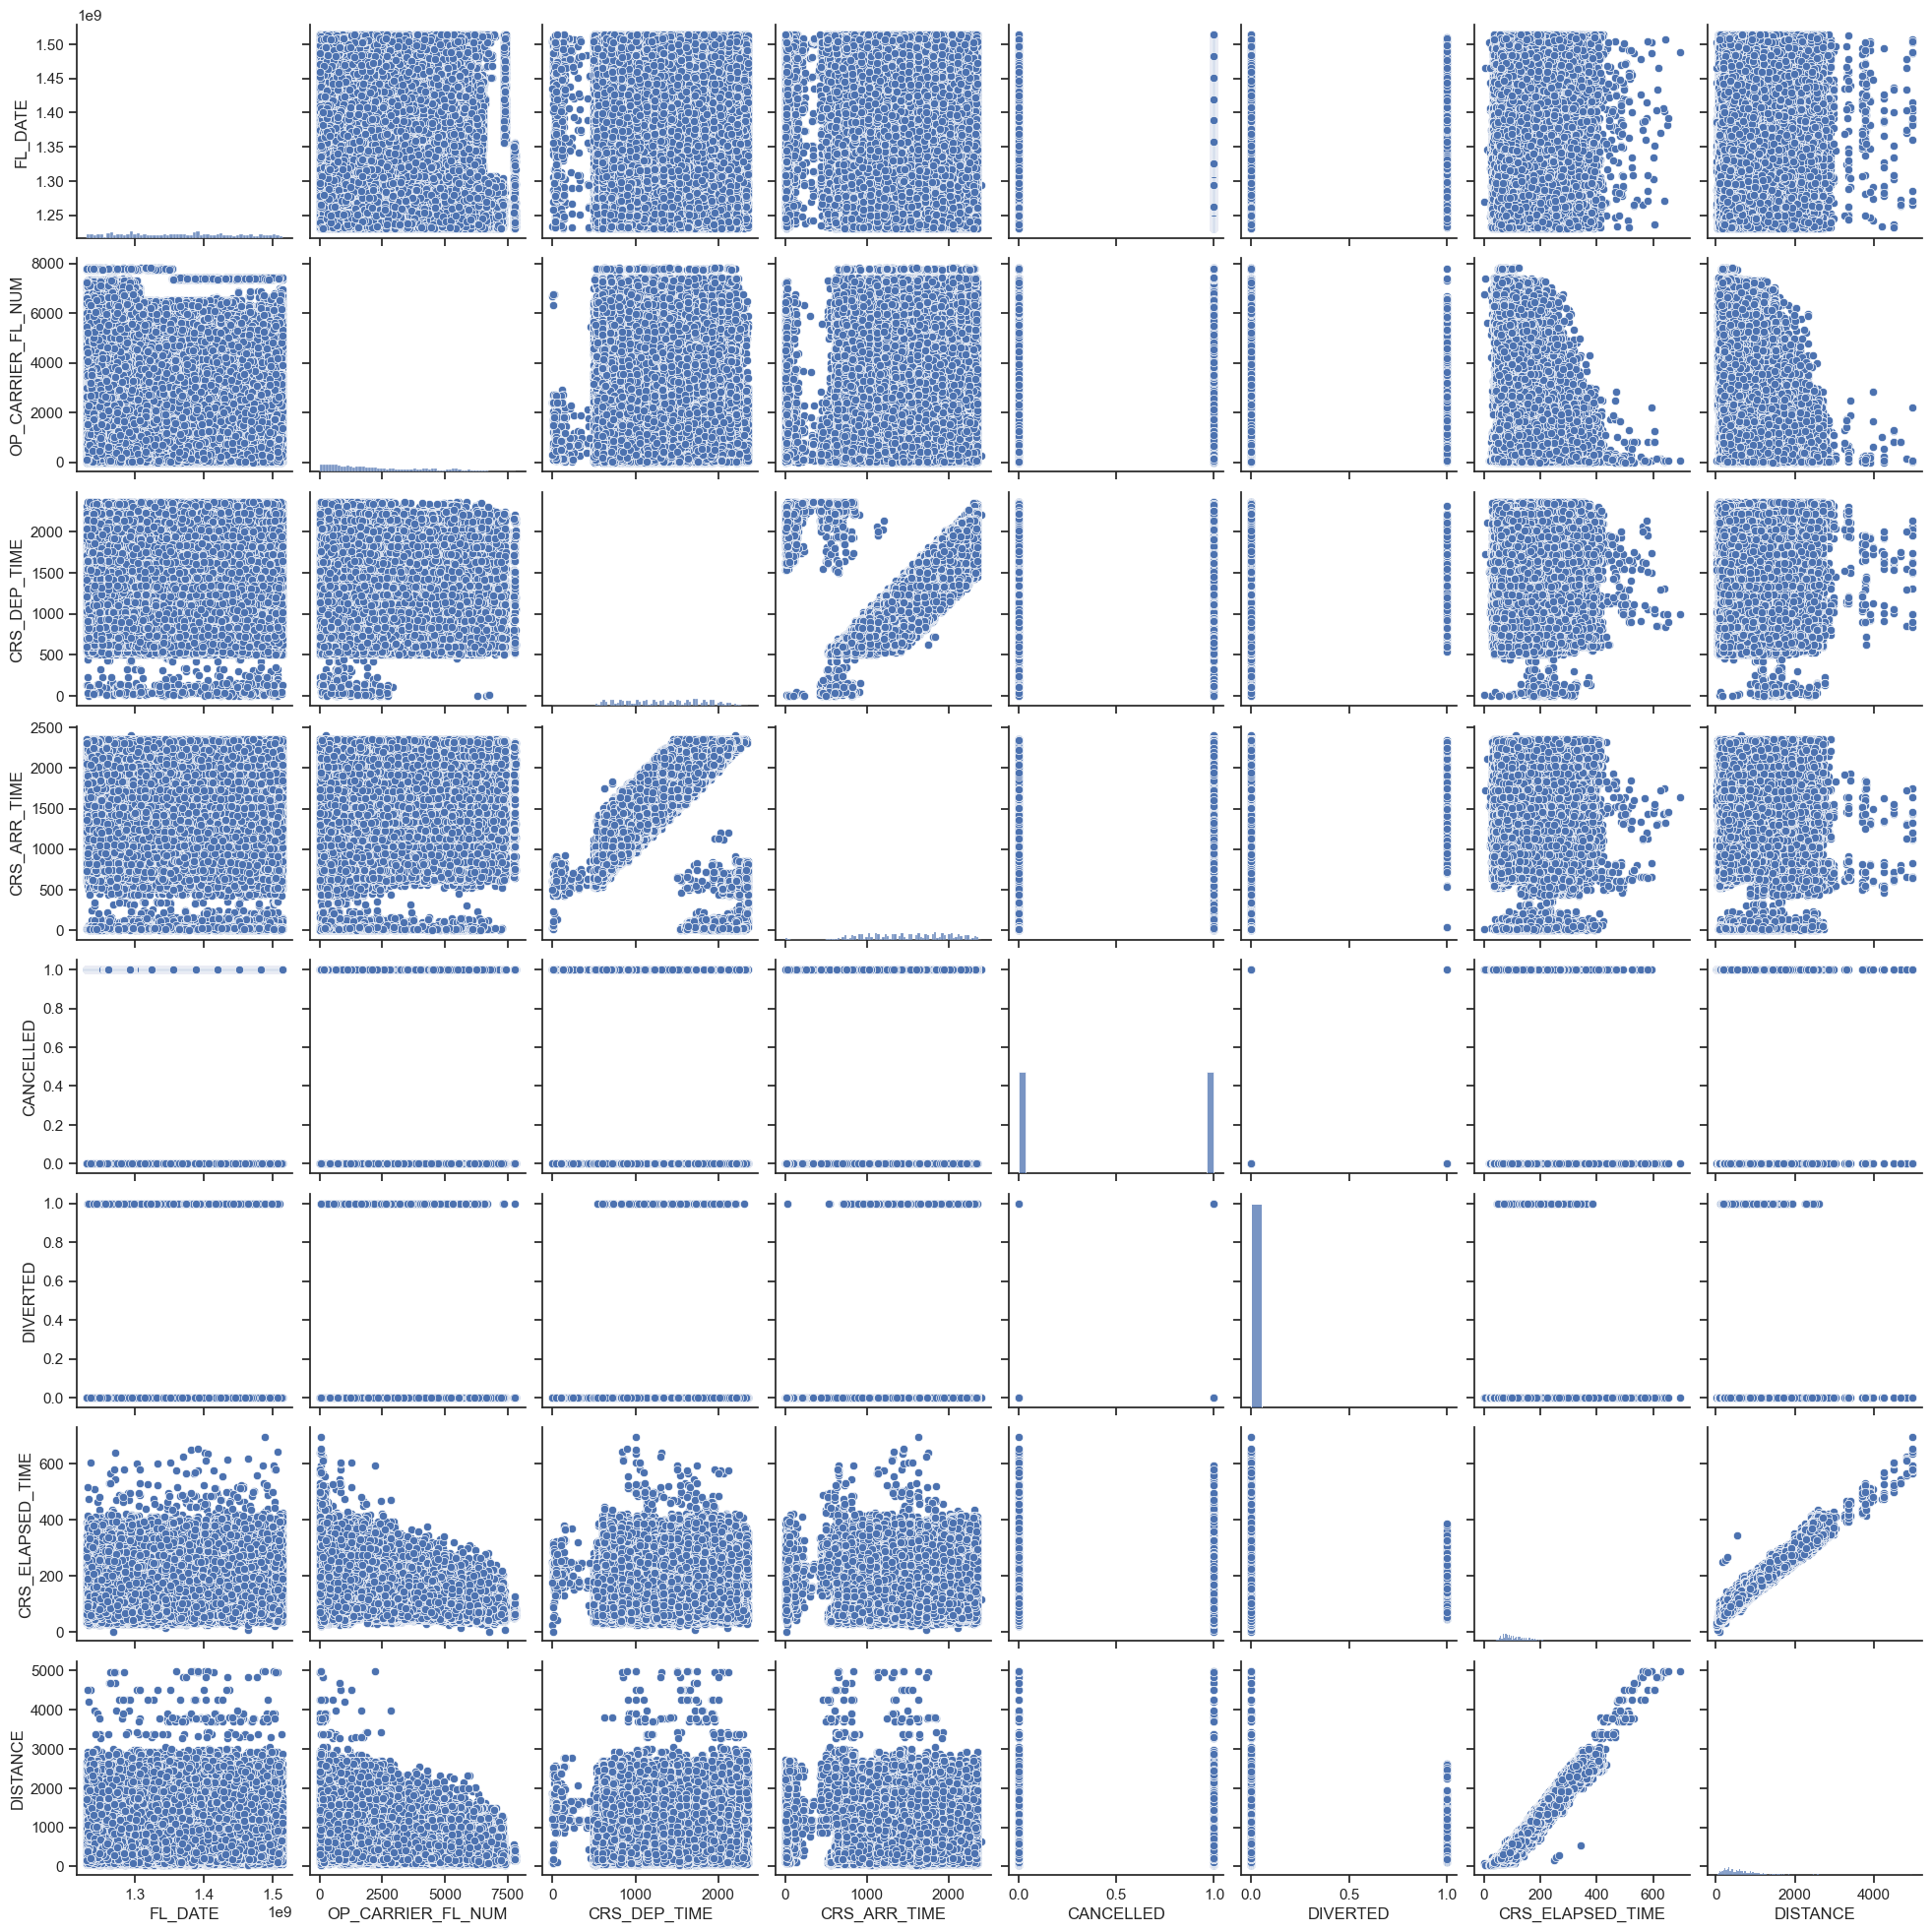

In [35]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(pdf)
plt.show()

Boxplot


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'FL_DATE'),
  Text(1, 0, 'OP_CARRIER_FL_NUM'),
  Text(2, 0, 'CRS_DEP_TIME'),
  Text(3, 0, 'CRS_ARR_TIME'),
  Text(4, 0, 'CANCELLED'),
  Text(5, 0, 'DIVERTED'),
  Text(6, 0, 'CRS_ELAPSED_TIME'),
  Text(7, 0, 'DISTANCE')])

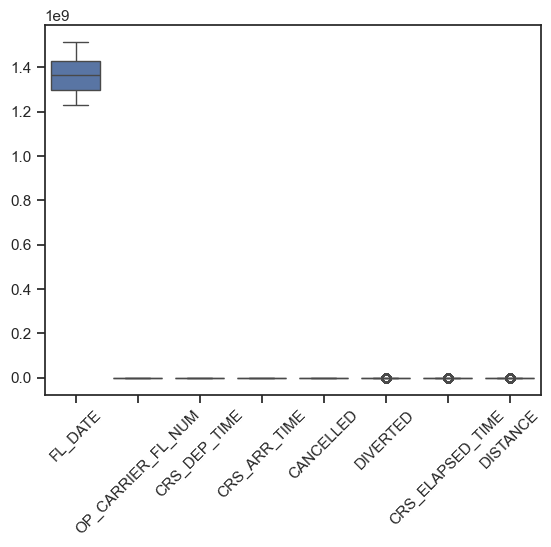

In [37]:
print("Boxplot")
sns.boxplot(pdf)
plt.xticks(rotation=45)

In [ ]:
#perlu normalisasi?